# ANÁLISE EXPLORATÓRIA - JOGOS OLÍMPICOS (1896 - 2016)
____

## 1. Introdução
Construir uma introdução com base histórica

## Importações
Aqui importamos as bibliotecas e definimos os caminhos de trabalho

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import os
import warnings
import requests
import branca
import folium
import json
import matplotlib.lines as lines
import matplotlib.colors as mcolors

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from folium import plugins
from folium.plugins import Search
from folium.plugins import HeatMap
from IPython.display import IFrame
from scipy.interpolate import splrep, splev

dir_atual = os.path.dirname(os.path.abspath('__file__'))
root_dir = os.path.abspath(os.path.join(dir_atual, '..'))
input_path = os.path.join(dir_atual, 'input')
formas_paises_url = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json'

warnings.filterwarnings('ignore')

sns.set()

%matplotlib inline

## Auxiliares

In [3]:
# Função para formatar os valores
def formata_valor(valor):
    if valor < 1_000:
        return f"{valor}"
    elif valor < 1_000_000:
        return f"{valor / 1_000:.0f} K"
    else:
        return f"{valor / 1_000_000:.1f} M"

In [4]:
# Cores especiais
cor_fundo_padrao = '#F4F3F5'
cinzas = ['#8A8A8A', '#5B5B5B', '#424242']
dourados = ["#fdf3da", "#fae3a2", "#f7d46a", "#F0C05A", "#D7A713"]
cores_verao = ['#FED0BD', '#FF6347']
cores_inverno = ['#A7C6DF','#4682B4']

## Carregar Arquivos
A principio, iremos carregar três arquivos: o arquivo de eventos, arquivo de regiões e por último o de coordenadas

In [5]:

dados = pd.read_csv(os.path.join(input_path, 'athlete_events.csv'))
regioes = pd.read_csv(os.path.join(input_path, 'noc_regions.csv'))

output_path = os.path.join(input_path, 'global_polygons.geojson')
response = requests.get(formas_paises_url)
if response.status_code == 200:
    with open(output_path, 'wb') as file:
        file.write(response.content)
else:
    raise 'Erro ao fazer o download do arquivo'

global_poligonos = gpd.read_file(output_path)
global_poligonos.to_file('global_polygons.geojson', driver='GeoJSON')

In [6]:
mesclado = pd.merge(dados, regioes, on='NOC', how='left')
mesclado.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN


## Visão Geral
____

### Distribuição de medalhas por competição

In [244]:
# Filtrando as competições por inverno e verão
comp_verao = mesclado[mesclado['Season']=='Summer']   
comp_inverno = mesclado[mesclado['Season']=='Winter']

# Quantidade de competições
num_comp_verao = comp_verao['Year'].nunique()           
num_comp_inverno = comp_inverno['Year'].nunique() 

# Quantidade de medalhas
num_medalhas_verao = comp_verao[comp_verao['Medal'].notna()]['Medal'].value_counts().sum()
num_medalhas_inverno = comp_inverno[comp_inverno['Medal'].notna()]['Medal'].value_counts().sum()

# Média de medalhas por competição
media_medalha_comp_verao = (num_medalhas_verao)/(num_comp_verao)
media_medalha_comp_inverno = (num_medalhas_inverno)/(num_comp_inverno)

texto_explicativo= f"""
Nos últimos 120 anos 
de comptição 
tivemos {num_comp_verao} competições
de verão e {num_comp_inverno} 
competições de inverno.\n
Foram distribuidas 
{num_medalhas_verao + num_medalhas_inverno} medalhas,
sendo {num_medalhas_verao} nas competições
de verão e {num_medalhas_inverno} 
nas competições de inverno.

Na média,
são distribuidas {media_medalha_comp_verao:.0f} 
medalhas por competição 
no verão e {media_medalha_comp_inverno:.0f} medalhas 
por competição no inverno"""



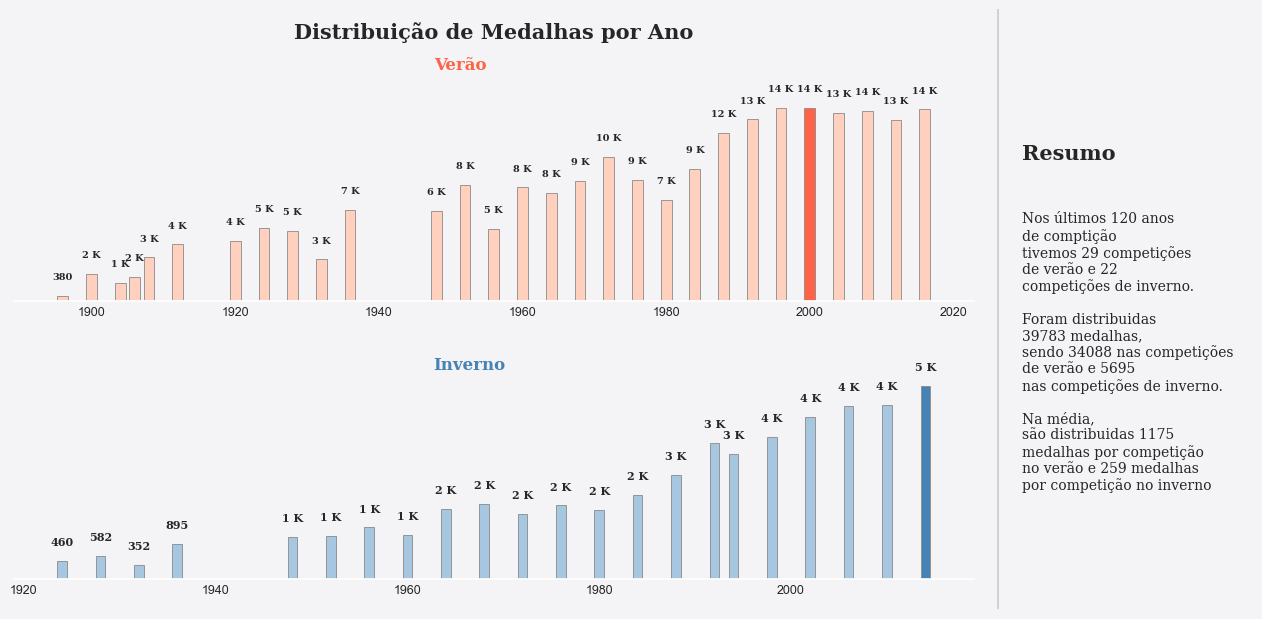

In [8]:
medalhas_ano_verao = comp_verao.groupby(['Year'])['Year'].value_counts().reset_index()
medalhas_ano_verao.set_index('Year', inplace=True)

medalhas_ano_inverno = comp_inverno.groupby(['Year'])['Year'].value_counts().reset_index()
medalhas_ano_inverno.set_index('Year', inplace=True)

medalhas_ano_verao = medalhas_ano_verao.sort_index()
medalhas_ano_inverno = medalhas_ano_inverno.sort_index()

max_verao = medalhas_ano_verao['count'].max()
max_inverno = medalhas_ano_inverno['count'].max()

# Preparar os mapas de cores
color_map_verao = [cores_verao[0] if count != max_verao else cores_verao[1] for count in medalhas_ano_verao['count']]
color_map_inverno = [cores_inverno[0] if count != max_inverno else cores_inverno[1] for count in medalhas_ano_inverno['count']]

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 6), facecolor=cor_fundo_padrao)

# As bordas de ambos os gráficos são removidas
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

# Plotando o primeiro grafico
ax.bar(x=medalhas_ano_verao.index, height=medalhas_ano_verao['count'],width=1.5, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map_verao
       )

# Adicionando os ródulos de dados
for i in medalhas_ano_verao.index:
    ax.annotate(f"{formata_valor(medalhas_ano_verao.at[i, 'count'])}", 
                xy=(i, medalhas_ano_verao.at[i, 'count'] + max_verao*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=7)

ax.grid()
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)
ax.set_ylim(0, max_verao * 1.2)
ax.set_facecolor(cor_fundo_padrao)

# Plotando o segundo grafico
ax2.bar(x=medalhas_ano_inverno.index, height=medalhas_ano_inverno['count'],width=1, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map_inverno
       )

# Adicionando rótulo de dados
for i in medalhas_ano_inverno.index:
    ax2.annotate(f"{formata_valor(medalhas_ano_inverno.at[i, 'count'])}", 
                xy=(i, medalhas_ano_inverno.at[i, 'count'] +  max_inverno*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=8)

ax2.grid()
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='both',length=0)
ax2.set_ylim(0, max_inverno * 1.2)
ax2.set_facecolor(cor_fundo_padrao)

# Definino uma linha vertical para separar o gráfico do resumo
l1 = lines.Line2D([0.92, 0.92], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)

# Configurações da figura
fig.suptitle('Distribuição de Medalhas por Ano', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.45, 0.9, 'Verão', fontsize=12, fontweight='bold', fontfamily='serif', color='#FF6347')
fig.text(0.45, 0.4, 'Inverno', fontsize=12, fontweight='bold', fontfamily='serif', color='#4682B4')
fig.text(0.94, 0.75, 'Resumo', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.94, 0.2, texto_explicativo, fontsize=10, fontweight='light', fontfamily='serif',ha='left')
fig.text(1.09, 0.3, 'margin', fontsize=10, fontweight='light', fontfamily='serif',ha='left', color=cor_fundo_padrao)
fig.lines.extend([l1])

# Ajustando os espaçamentos
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.05)


### Distribuição de Medalhas por País

#### Preparando os dados

In [9]:
df = mesclado

df.replace('USA', "United States of America", inplace = True)
df.replace('Tanzania', "United Republic of Tanzania", inplace = True)
df.replace('Democratic Republic of Congo', "Democratic Republic of the Congo", inplace = True)
df.replace('Congo', "Republic of the Congo", inplace = True)
df.replace('Lao', "Laos", inplace = True)
df.replace('Syrian Arab Republic', "Syria", inplace = True)
df.replace('Serbia', "Republic of Serbia", inplace = True)
df.replace('Czechia', "Czech Republic", inplace = True)
df.replace('UAE', "United Arab Emirates", inplace = True)
df.replace('UK', "United Kingdom", inplace = True)

medalhas_regiao = df.groupby(['region', 'Medal'])['Medal'].value_counts().unstack().fillna(0).astype(int)
medalhas_regiao['Total'] = medalhas_regiao['Bronze'] + medalhas_regiao['Silver'] + medalhas_regiao['Gold']

medalhas_regiao_temp = medalhas_regiao.reset_index()

medalhas_mapeadas = pd.merge(global_poligonos, medalhas_regiao_temp, left_on='name', right_on='region')

#### Mapa de calor - Distribuição de medalhas por País

In [226]:
def rd2(x):
    return round(x, 2)

def style_function(x):
    return {
        "fillColor": mapa_colorido(x["properties"]["Total"]),
        "color": "#5B5B5B",
        "weight": 2,
        "fillOpacity": 0.5,
    }

minino, maximo = medalhas_mapeadas['Total'].quantile([0.05, 0.95]).apply(rd2)

mean = round(medalhas_mapeadas["Total"].mean(), 2)

mapa_colorido = branca.colormap.LinearColormap(
    colors=dourados,
    index=medalhas_mapeadas["Total"].quantile([0.25, 0.5, 0.85, 0.95]),
    vmin=minino,
    vmax=maximo,
)

mapa_colorido.caption = "Total de medalhas"

m = folium.Map(location=(50,0),zoom_start=3)

camada = folium.GeoJson(
    medalhas_mapeadas,
    name="Medalhas",
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=["name","Total","Gold","Silver","Bronze"], 
        aliases=["Páis","Total de Medalhas","Ouro","Prata","Bronze"], localize=True
    ),
).add_to(m)

minimap = plugins.MiniMap()
m.add_child(minimap)

folium.LayerControl().add_to(m)
mapa_colorido.add_to(m)

m.save('mapa.html')
m

<br><br>

## Participação Feminina
___

Agora analisaremos um pouco da participação das mulheres durante os anos de competição.

### Distribuição de Medalhas pelo Anos

Text(0.45, 0.4, 'Inverno')

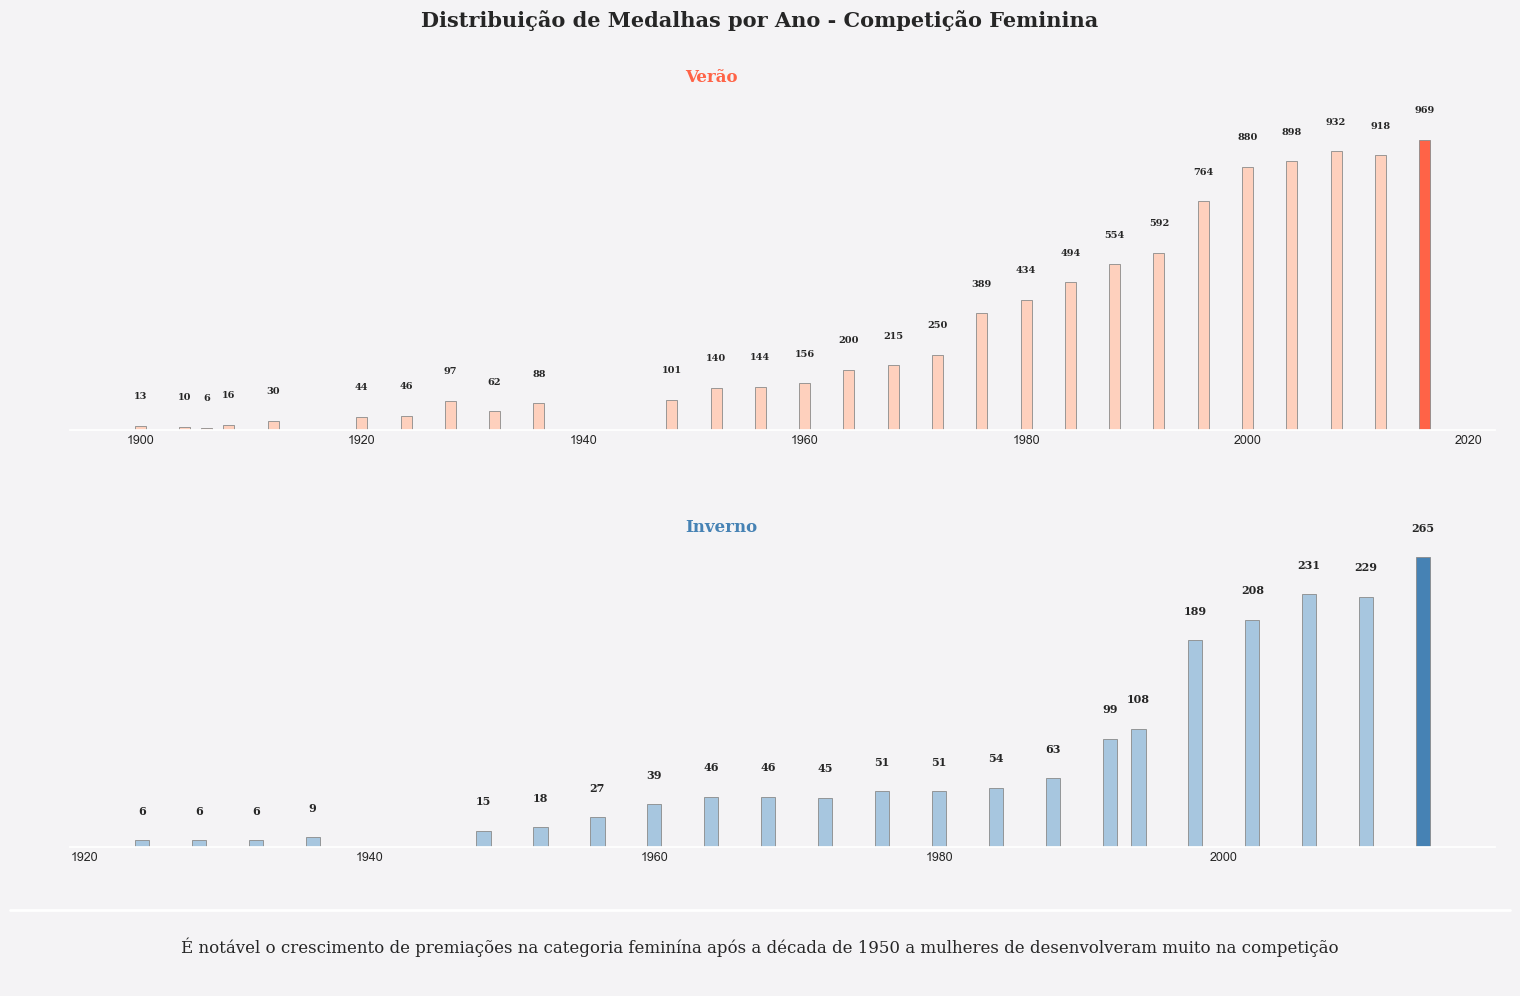

In [11]:
mulheres_verao = mesclado[(mesclado.Sex == 'F') & (mesclado.Season == "Summer")]
mulheres_verao = mulheres_verao.groupby(['Year'])['Medal'].count().reset_index()
mulheres_verao.set_index('Year', inplace=True)

mulhes_inverno = mesclado[(mesclado.Sex == 'F') & (mesclado.Season == "Winter")]
mulhes_inverno = mulhes_inverno.groupby(['Year'])['Medal'].count().reset_index()
mulhes_inverno.set_index('Year', inplace=True)

max_verao = mulheres_verao['Medal'].max()
max_inverno = mulhes_inverno['Medal'].max()

# Preparar os mapas de cores
color_map_verao = [cores_verao[0] if count != max_verao else cores_verao[1] for count in mulheres_verao['Medal']]
color_map_inverno = [cores_inverno[0] if count != max_inverno else cores_inverno[1] for count in mulhes_inverno['Medal']]

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 9), facecolor=cor_fundo_padrao)

# As bordas de ambos os gráficos são removidas
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

# Definindo a cor de fundo dos gráficos
ax.set_facecolor(cor_fundo_padrao)
ax2.set_facecolor(cor_fundo_padrao)


# Plotando os graficos em seus eixos
ax.bar(x=mulheres_verao.index, height=mulheres_verao['Medal'],width=1, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map_verao
       )

ax2.bar(x=mulhes_inverno.index, height=mulhes_inverno['Medal'],width=1, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map_inverno
       )

# Inserindo os rotulos de dados
for i in mulheres_verao.index:
    ax.annotate(f"{formata_valor(mulheres_verao.at[i, 'Medal'])}", 
                xy=(i, mulheres_verao.at[i, 'Medal'] + max_verao*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=7)
    
# Adicionando rótulo de dados
for i in mulhes_inverno.index:
    ax2.annotate(f"{formata_valor(mulhes_inverno.at[i, 'Medal'])}", 
                xy=(i, mulhes_inverno.at[i, 'Medal'] +  max_inverno*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=8)

# Modificando os eixos
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)
ax.set_ylim(0, max_verao * 1.2)
ax.set_facecolor(cor_fundo_padrao)

ax2.grid()
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='both',length=0)
ax2.set_ylim(0, max_inverno * 1.2)
ax2.set_facecolor(cor_fundo_padrao)

fig.suptitle('Distribuição de Medalhas por Ano - Competição Feminina', fontsize=15, fontweight='bold', fontfamily='serif')

l1 = lines.Line2D([0, 1], [-0.02, -0.02], transform=fig.transFigure, figure=fig, color='white', lw=2)
fig.lines.extend([l1])

texto = """
    É notável o crescimento de premiações na categoria feminína após a década de 1950 a mulheres de desenvolveram muito na competição
"""

fig.text(0.1, -0.09, texto, fontsize=12, fontweight='light', fontfamily='serif', ha='left')
fig.text(0.1, -0.1, 'margin', fontsize=12, fontweight='light', fontfamily='serif', ha='left', color=cor_fundo_padrao)


plt.subplots_adjust(left=0.04, right=0.99, top=0.9, bottom=0.05)
fig.text(0.45, 0.9, 'Verão', fontsize=12, fontweight='bold', fontfamily='serif', color='#FF6347')
fig.text(0.45, 0.4, 'Inverno', fontsize=12, fontweight='bold', fontfamily='serif', color='#4682B4')

### Evolução do número de competidoras

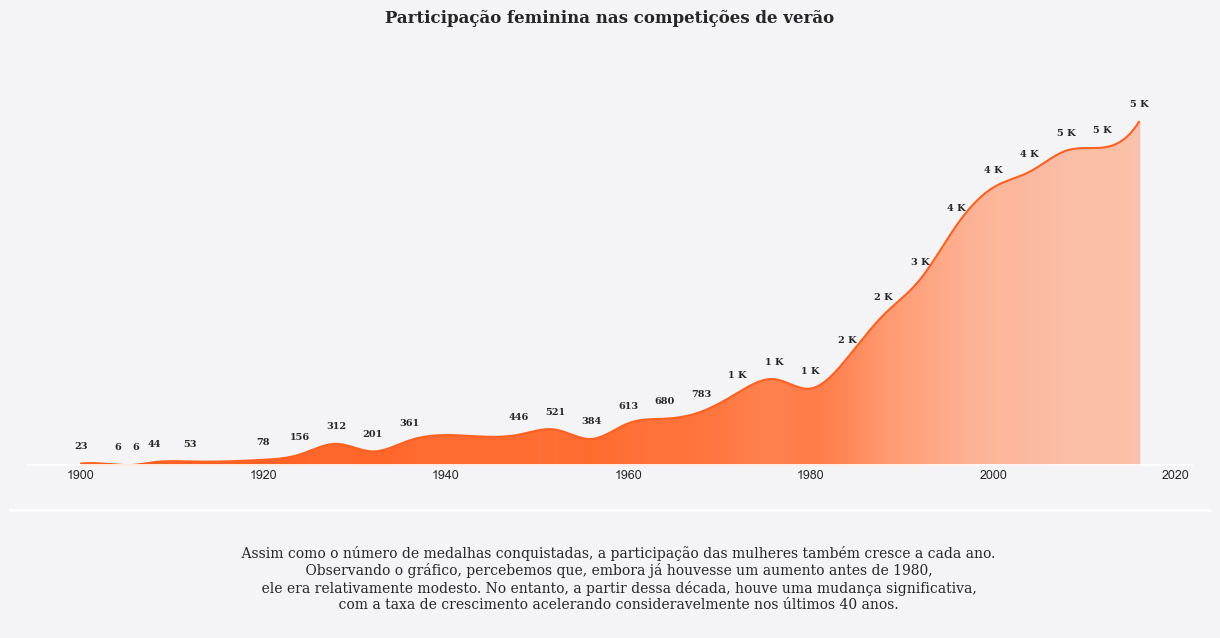

In [12]:
mulheres_unicas = mesclado[(mesclado.Sex == 'F') & (mesclado.Season == "Summer")].drop_duplicates(subset=['ID', 'Year'])
mulheres_unicas = mulheres_unicas.groupby(['Year'])['Year'].value_counts().sort_index(ascending=True).reset_index()
mulheres_unicas.set_index('Year', inplace=True)

max_ = mulheres_unicas['count'].max()

# Dados do gráfico
x = mulheres_unicas.index.values
y = mulheres_unicas['count'].values

spl = splrep(x, y)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = splev(x_smooth, spl)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), facecolor=cor_fundo_padrao)

ax.plot(x_smooth, y_smooth, marker='', linestyle='-', color='#FF6122')
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)
ax.set_ylim(0, max_ * 1.2)
ax.set_facecolor(cor_fundo_padrao)

for i in mulheres_unicas.index:
    ax.annotate(f"{formata_valor(mulheres_unicas.at[i, 'count'])}", 
                xy=(i, mulheres_unicas.at[i, 'count'] + max_*0.05),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=7)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Criando um degradê de cores para o preenchimento
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

cmap = LinearSegmentedColormap.from_list("golden_gradient", [ "#FF6122", "#FFA07A", "#FAC3AE"])
norm = mcolors.Normalize(vmin=y_smooth.min(), vmax=y_smooth.max())

# Preenchendo o gráfico com o degradê
for i in range(len(x_smooth) - 1):
    ax.fill_between(x_smooth[i:i + 2], y1=y_smooth[i:i + 2], y2=0, color=cmap(norm(y_smooth[i])))

l1 = lines.Line2D([0, 1], [-0.02, -0.02], transform=fig.transFigure, figure=fig, color='white', lw=2)
fig.lines.extend([l1])

texto = """
    Assim como o número de medalhas conquistadas, a participação das mulheres também cresce a cada ano.
    Observando o gráfico, percebemos que, embora já houvesse um aumento antes de 1980,
    ele era relativamente modesto. No entanto, a partir dessa década, houve uma mudança significativa,
    com a taxa de crescimento acelerando consideravelmente nos últimos 40 anos.
"""

fig.text(0.5, -0.25, texto, fontsize=10, fontweight='light', fontfamily='serif', ha='center')
fig.text(0.1, -0.17, 'margin', fontsize=12, fontweight='light', fontfamily='serif', ha='left', color=cor_fundo_padrao)

plt.subplots_adjust(left=0.04, right=0.99, top=0.9, bottom=0.05)
plt.suptitle('Participação feminina nas competições de verão', fontsize=12, fontweight='bold', fontfamily='serif')
plt.tight_layout()

<br><br>
## Medalhas de Ouro
___

Veremos nessa seção a distribuição de medalhas de ouro por certas categorias.

### Medalhas de ouro por País

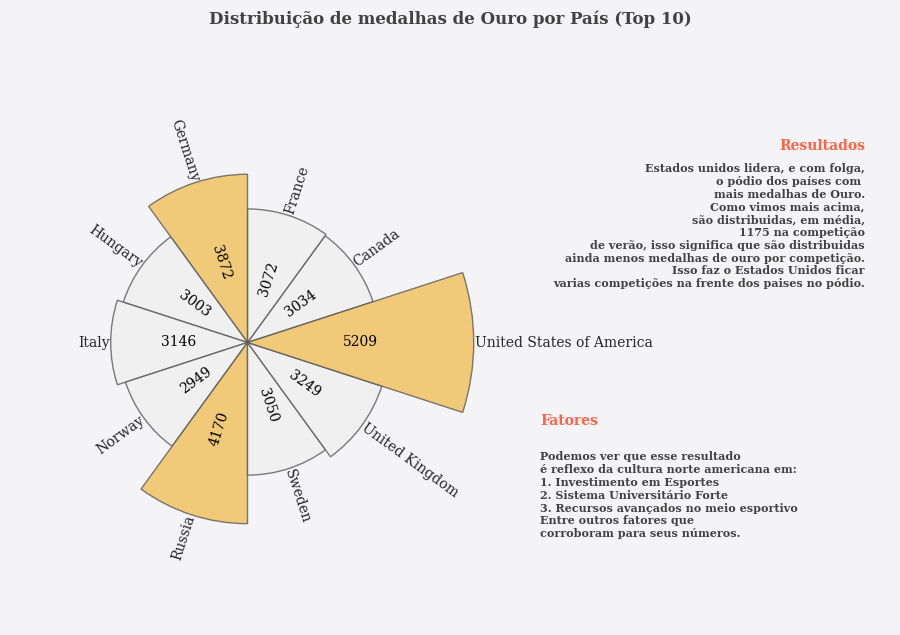

In [13]:
medalhas_ouro_regiao = mesclado.query("Medal == 'Gold'").groupby(['region'])['Medal'].value_counts().unstack()
medalhas_ouro_regiao = medalhas_ouro_regiao.sort_values(by='Gold', ascending=False).reset_index()

top_10_medalhas_ouro = medalhas_ouro_regiao[:10]

ranking_map = {region: i for i, region in enumerate(top_10_medalhas_ouro['region'])}

top_10_medalhas_ouro = top_10_medalhas_ouro.sort_values(by='region').set_index('region').reset_index()

color_map = ['#F0F0F0' for _ in range(0, 10)]   # Definindo as cores
for i, region in enumerate(top_10_medalhas_ouro['region']):
    if ranking_map[region] < 3:  # Se estiver nos três primeiros no ranking original
        color_map[i] = '#F0C05A'  # Cor de destaque

fig, ax1 = plt.subplots(1,1, figsize=(5,5), facecolor=cor_fundo_padrao)
ax = plt.subplot(111, polar=True)
ax1.set_facecolor(cor_fundo_padrao)
ax1.grid()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
for s in ['top', 'left', 'right', 'bottom']:
    ax1.spines[s].set_visible(False)

upperLimit = 3000   # Limite superior das fatias
lowerLimit = 10     # Limite inferior das fatias (onde começam em relação ao eixo cartesiano)
labelPadding = 35   # Define a distância mínima do rótulo do país

max_ = top_10_medalhas_ouro['Gold'].max()
min_ = top_10_medalhas_ouro['Gold'].min()

# Calcula a angulatura da barra
slope = (max_ - lowerLimit) / (max_ - min_)  
alturas = slope * top_10_medalhas_ouro['Gold'] + (upperLimit- lowerLimit)
indexes = list(range(1, len(top_10_medalhas_ouro.index)+1))
largura = 2*np.pi / len(top_10_medalhas_ouro.index)
angulos = [element * largura for element in indexes]

# Configurando as barras (slices) do nosso gráfico
bars = ax.bar(
    x=angulos, 
    height=alturas, 
    width=largura, 
    bottom=lowerLimit,
    linewidth=1, 
    edgecolor=cinzas[-2],
    color=color_map, alpha=0.8
)

# Itera sobre as regiões para adicionar os rótulos de dados e labels dos países
for barra, angulo, altura, label in zip(bars, angulos, alturas, top_10_medalhas_ouro["region"]):

    rotacao = np.rad2deg(angulo)   # Converte radianos para graus

    alinhamento = ""
    if angulo >= np.pi/2 and angulo < 3*np.pi/2:  # Se estiver entre o segundo e terceiro quadrante, mudamos o alinhamento
        alinhamento = "right"
        rotacao = rotacao + 180
    else: 
        alinhamento = "left"

    # Adiciona o label
    ax.text(
        x=angulo, 
        y=lowerLimit + barra.get_height() + labelPadding, 
        s=label, 
        ha=alinhamento, fontsize=10, fontfamily='serif',
        va='center', 
        rotation=rotacao, 
        rotation_mode="anchor"
    )

    # Adiciona o rótulo de dados
    ax.text(
        x=angulo, 
        y=lowerLimit + barra.get_height()/2,
        s=f"{int(barra.get_height() / slope)}", 
        ha='center', fontsize=10, fontfamily='serif',
        va='center', color='black', rotation=rotacao, 
        rotation_mode="anchor"
    )

texto = f"""
Estados unidos lidera, e com folga,
o pódio dos países com 
mais medalhas de Ouro.
Como vimos mais acima,
são distribuidas, em média,
{media_medalha_comp_verao:.0f} na competição
de verão, isso significa que são distribuidas
ainda menos medalhas de ouro por competição.
Isso faz o Estados Unidos ficar
varias competições na frente dos paises no pódio.
"""

texto2 = """
Podemos ver que esse resultado
é reflexo da cultura norte americana em:
1. Investimento em Esportes
2. Sistema Universitário Forte
3. Recursos avançados no meio esportivo
Entre outros fatores que
corroboram para seus números.
"""

# Adicionando textos e ajustes finais
fig.text(1.75, 0.7, "Resultados", fontsize=10, fontweight='bold', fontfamily='serif', ha='right', color=cores_verao[-1])
fig.text(1.75, 0.4, texto, fontsize=8, fontweight='bold', fontfamily='serif', ha='right', color=cinzas[-1])
fig.text(1.1, 0.15, "Fatores", fontsize=10, fontweight='bold', fontfamily='serif', ha='left', color=cores_verao[-1])
fig.text(1.1, -0.1, texto2, fontsize=8, fontweight='bold', fontfamily='serif', ha='left', color=cinzas[-1])
fig.text(1.8, -0.17, 'margin', fontsize=12, fontweight='light', fontfamily='serif', ha='right', color=cor_fundo_padrao)

plt.axis('off')
plt.suptitle('Distribuição de medalhas de Ouro por País (Top 10)',
            fontsize=12, fontweight='bold', fontfamily='serif', x=0.92, color=cinzas[-1])
plt.subplots_adjust(left=0.04, right=0.99, top=0.88, bottom=-0.25)


### Medalhas de Ouro por Esporte

Vamos explorar os esportes e descobrir quem se destaca na competição.

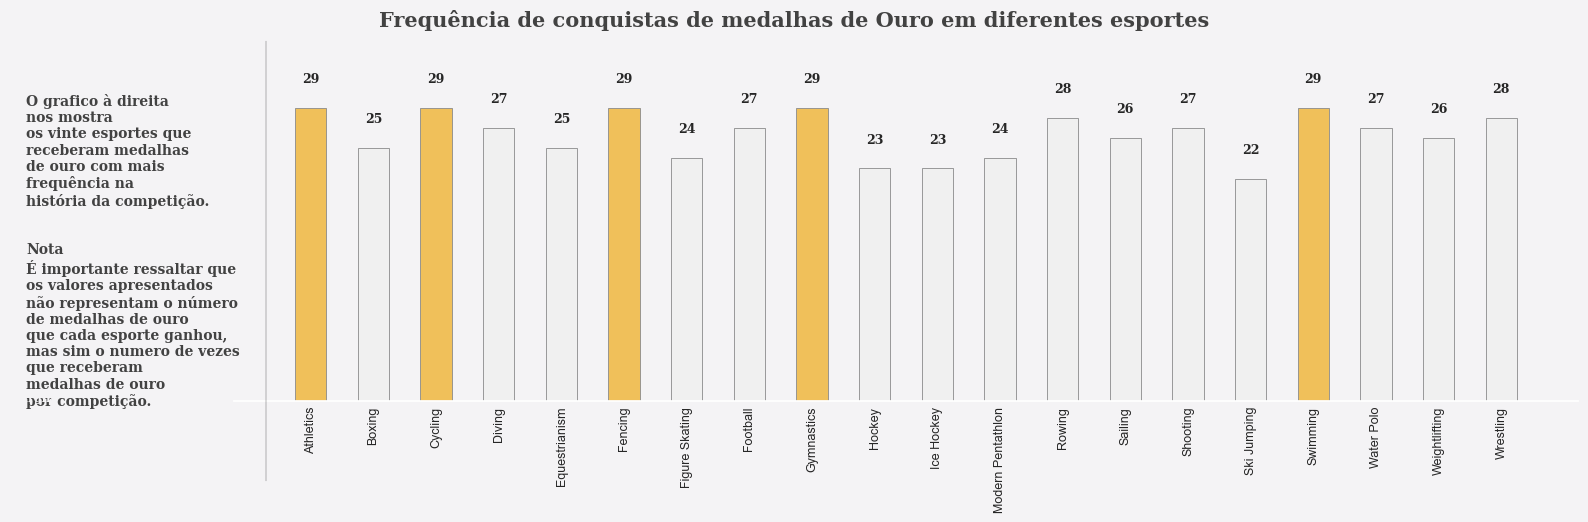

In [14]:
medalhas_ouro_regiao = mesclado.query("Medal == 'Gold'").groupby(['Year', 'Sport']).first()
top_20_esportes_ouro = medalhas_ouro_regiao.reset_index()['Sport'].value_counts().reset_index()[:20]

max_ = top_20_esportes_ouro['count'].max()

ranking_sport = {sport: i for i, sport in enumerate(top_20_esportes_ouro['Sport'])}

top_20_esportes_ouro = top_20_esportes_ouro.sort_values(by='Sport').set_index('Sport').reset_index()

color_map = ['#F0F0F0' for _ in range(0, 20)]   # Definindo as cores
for i, e in enumerate(top_20_esportes_ouro['Sport']):
    if top_20_esportes_ouro.iloc[i]['count'] == max_:
        color_map[i] = '#F0C05A'  # Cor de destaque

fig, ax = plt.subplots(1,1, figsize=(16,4), facecolor=cor_fundo_padrao)

# Plotando os graficos em seus eixos
ax.bar(x=top_20_esportes_ouro['Sport'], height=top_20_esportes_ouro['count'],width=0.5, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map
       )

# Modificando os eixos
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)
ax.set_ylim(0, max_ * 1.2)
ax.set_facecolor(cor_fundo_padrao)
ax.set_xticklabels(top_20_esportes_ouro['Sport'], rotation=90)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Inserindo os rotulos de dados
for i in top_20_esportes_ouro.index:
    ax.annotate(f"{formata_valor(top_20_esportes_ouro.at[i, 'count'])}", 
                xy=(i, top_20_esportes_ouro.at[i, 'count'] + max_*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=9)

texto1 = '''
O grafico à direita 
nos mostra
os vinte esportes que
receberam medalhas
de ouro com mais
frequência na 
história da competição.


Nota
É importante ressaltar que
os valores apresentados
não representam o número
de medalhas de ouro
que cada esporte ganhou,
mas sim o numero de vezes
que receberam 
medalhas de ouro
por competição.
'''

plt.suptitle('Frequência de conquistas de medalhas de Ouro em diferentes esportes',
            fontsize=15, fontweight='bold', fontfamily='serif', ha='center', color=cinzas[-1])
fig.text(0.02, -0.05, texto1, fontsize=10, fontweight='bold', fontfamily='serif', ha='left', color=cinzas[-1])
fig.text(0.01, 0, 'margin', fontsize=8, fontweight='bold', fontfamily='serif', ha='left', color=cor_fundo_padrao)

l1 = lines.Line2D([0.17, 0.17], [-0.2, 0.9], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

plt.tight_layout()
plt.subplots_adjust(left=0.15, right=0.99, top=0.88, bottom=-0)


### Medalhas de Ouro por Idade

Agora, vamos verificar a distribuição de medalhas de ouro por Idade. Qual a idade que mais recebe as medalhas douradas?

Text(0.44, 0.48, '\nComo podemos notar, a faixa etária dos 20 anos de idade é quem recebe o maior numero de medalhas de ouro.\nAbaixo iremos abrir os extremos do grafico e analisar quais esportes estão atrelados a esses atletas.\n')

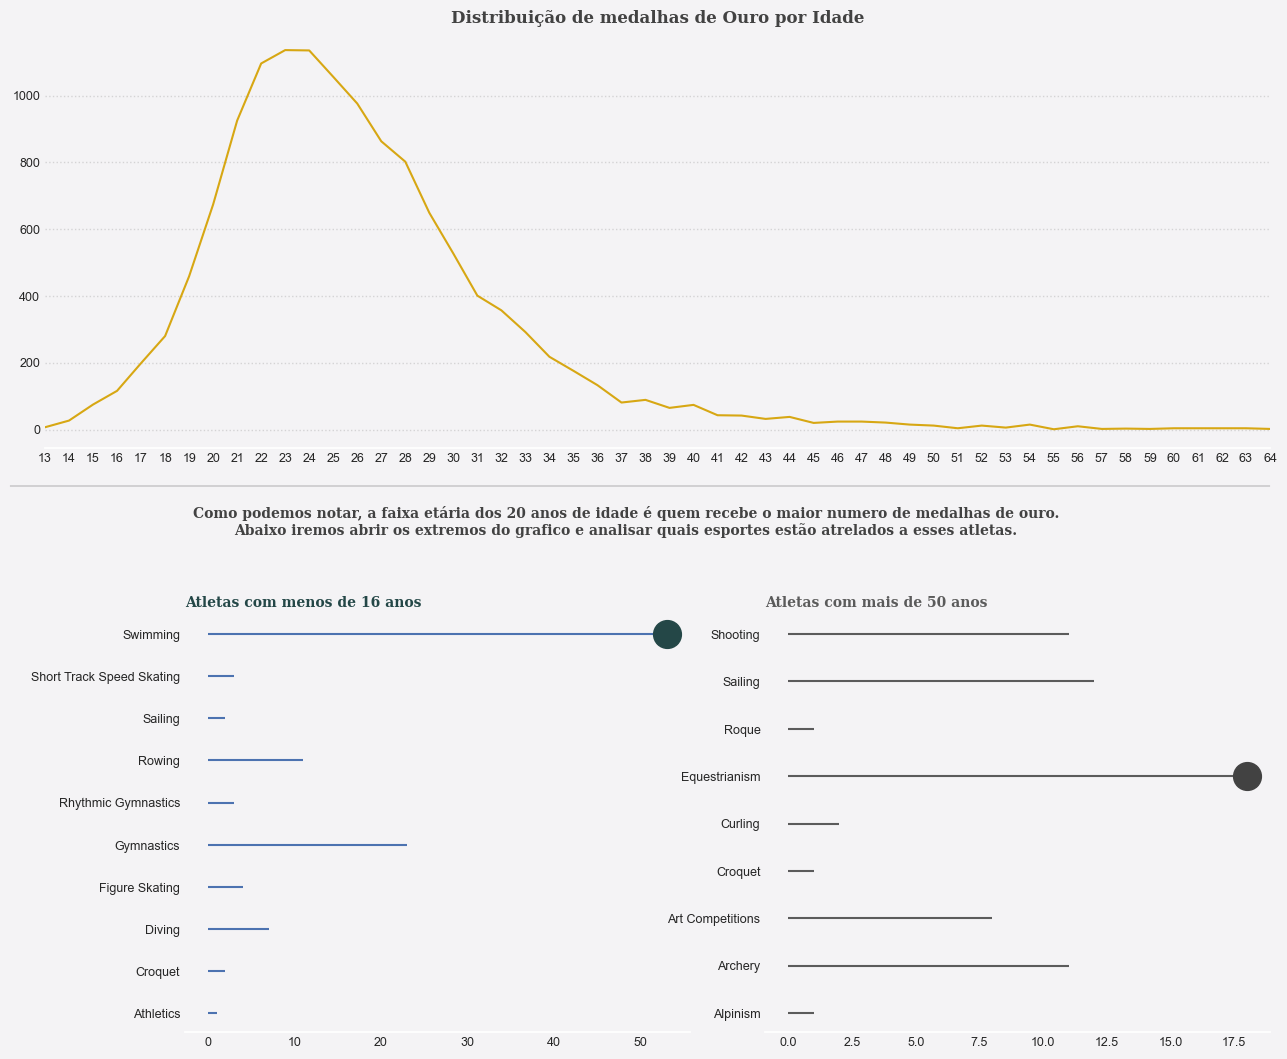

In [15]:
medalhas_ouro = mesclado.query("Medal == 'Gold'")
medalhas_ouro = medalhas_ouro[np.isfinite(medalhas_ouro['Age'])]
medalhas_ouro['Age'] = medalhas_ouro['Age'].astype(int)

fig = plt.figure(figsize=(14, 13), facecolor=cor_fundo_padrao)

# Primeiro subplot que ocupa toda a linha superior
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)

# Segundo subplot na segunda linha, primeira coluna
ax2 = plt.subplot2grid((2, 2), (1, 0))

# Terceiro subplot na segunda linha, segunda coluna
ax3 = plt.subplot2grid((2, 2), (1, 1))

# Aplicando configuraçções gerais para cada subplot
for ax_ in [ax, ax2, ax3]:
    ax_.grid()
    for s in ['top', 'left', 'right']:
        ax_.spines[s].set_visible(False)
    ax_.tick_params(axis='both', which='major', labelsize=9)
    ax_.tick_params(axis='both', which='both',length=0)
    ax_.set_facecolor(cor_fundo_padrao)

# Grafico 1: Distribuição de medalhas por idade
medalhas_ouro_idade = medalhas_ouro.groupby('Age')['Age'].value_counts().reset_index()

ax.plot(medalhas_ouro_idade['Age'], medalhas_ouro_idade['count'], linestyle='-', color=dourados[-1])
full_age_range = np.arange(medalhas_ouro_idade['Age'].min(), medalhas_ouro_idade['Age'].max() + 1)
ax.set_xticks(full_age_range)
ax.set_xlim(medalhas_ouro_idade['Age'].min(), medalhas_ouro_idade['Age'].max())
ax.yaxis.grid(True, linestyle=':', which='both', color=cinzas[0], alpha=0.3)
ax.set_title('Distribuição de medalhas de Ouro por Idade',
            fontsize=12, fontweight='bold', fontfamily='serif', ha='center', color=cinzas[-1])

# Grafico 2: Distribuição de Medalhas por Esporte (< 16 anos)
medalhas_ouro_16 = medalhas_ouro.query("Age < 16").groupby('Sport')['Sport'].value_counts().reset_index()

x_min_16 = medalhas_ouro_16['count'].min()
x_max_16 = medalhas_ouro_16['count'].max()

ax2.hlines(y=medalhas_ouro_16['Sport'],xmin=0, xmax=medalhas_ouro_16['count'])
ax2.plot(medalhas_ouro_16[medalhas_ouro_16['count']==x_max_16]['count'],
        medalhas_ouro_16[medalhas_ouro_16['count']==x_max_16]['Sport'],
        'o', markersize=20, color='#244747')
ax2.set_title('Atletas com menos de 16 anos', loc='left', color='#244747', fontsize=10, fontweight='bold', fontfamily='serif')

# Grafico 3: Distribuição de Medalhas por Esporte (> 50 anos)
medalhas_ouro_50 = medalhas_ouro.query("Age > 50").groupby('Sport')['Sport'].value_counts().reset_index()

x_min_50 = medalhas_ouro_50['count'].min()
x_max_50 = medalhas_ouro_50['count'].max()

ax3.hlines(y=medalhas_ouro_50['Sport'],xmin=0, xmax=medalhas_ouro_50['count'], colors=cinzas[-2])
ax3.plot(medalhas_ouro_50[medalhas_ouro_50['count']==x_max_50]['count'],
        medalhas_ouro_50[medalhas_ouro_50['count']==x_max_50]['Sport'],
        'o', markersize=20, color= cinzas[-1])
ax3.set_title('Atletas com mais de 50 anos', loc='left', color=cinzas[-2], fontsize=10, fontweight='bold', fontfamily='serif')

plt.subplots_adjust(hspace=0.4, wspace=0.15)

l1 = lines.Line2D([0, 0.9], [0.53, 0.53], transform=fig.transFigure, figure=fig, color='black', lw=.2)
fig.lines.extend([l1])

# Ajuste manual da posição do ax pois os dados dos gráficos abaixo podem alterar sua posição 
box = ax.get_position()
ax.set_position([box.x0 - 0.1, box.y0, box.width + 0.1, box.height])

# Textos
texto1 = """
Como podemos notar, a faixa etária dos 20 anos de idade é quem recebe o maior numero de medalhas de ouro.
Abaixo iremos abrir os extremos do grafico e analisar quais esportes estão atrelados a esses atletas.
"""

fig.text(0.44,0.48, s=texto1, fontsize=10, fontweight='bold', fontfamily='serif', ha='center', color=cinzas[-1])


<br><br>

## Atletas
____

Agora vamos descobrir um pouco mais sobre os nossos queridos atletas.


### Peso x Altura

In [16]:
# Limpando a tabela, pois temos linhas com peso e alturas vazias

peso_altura = mesclado[np.isfinite(mesclado['Height'])]
peso_altura = peso_altura[np.isfinite(mesclado['Weight'])]

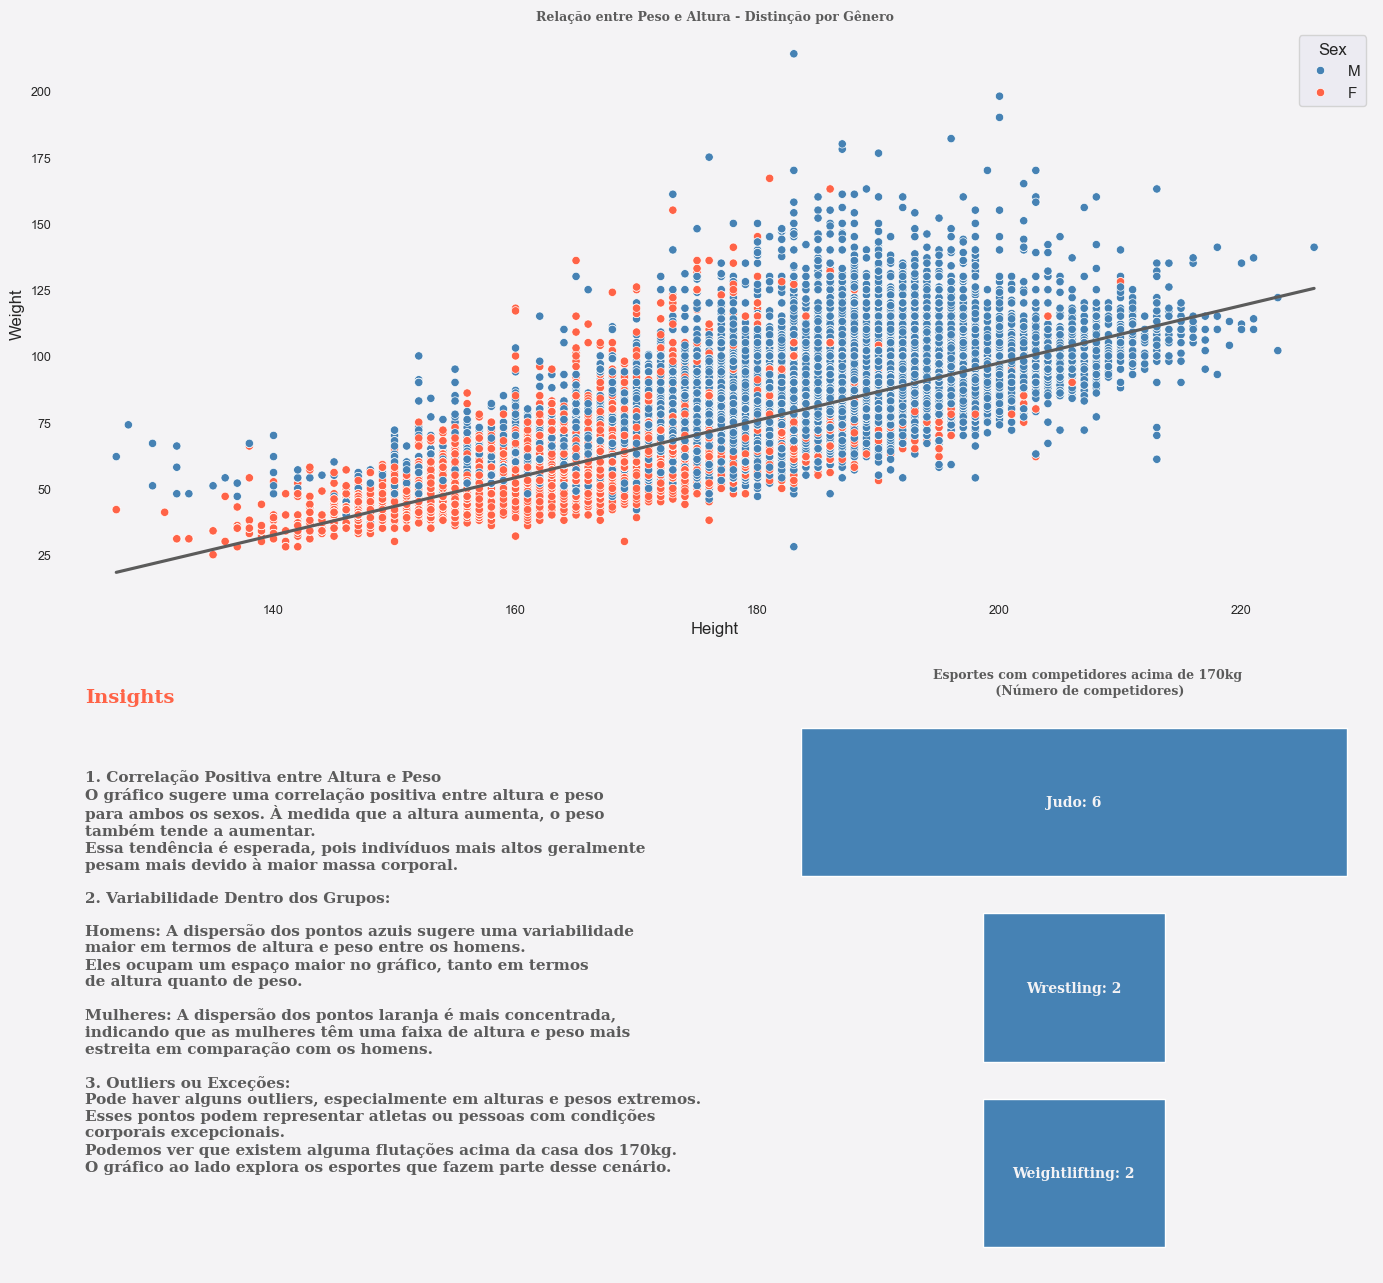

In [227]:
fig = plt.figure(figsize=(14, 13), facecolor=cor_fundo_padrao)

# Primeiro subplot que ocupa toda a linha superior
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)

# Segundo subplot na segunda linha, primeira coluna
ax2 = plt.subplot2grid((2, 2), (1, 0))

# Terceiro subplot na segunda linha, segunda coluna
ax3 = plt.subplot2grid((2, 2), (1, 1))

# Grafico 1: RElação entre Peso e Altura
paleta = {'F': cores_verao[-1], 'M': cores_inverno[-1]}

sns.scatterplot(x=peso_altura['Height'], y=peso_altura['Weight'],
                hue=peso_altura['Sex'], data=peso_altura,
                ax=ax, palette=paleta)

# Adicionando uma linha de tendência (regressão linear)
sns.regplot(x='Height', y='Weight', data=peso_altura, scatter=False, ax=ax, color=cinzas[-2])

ax.set_title('Relação entre Peso e Altura - Distinção por Gênero',
        color=cinzas[-2], fontsize=9, fontweight='bold', fontfamily='serif')

# Grafico 2: Explorando os outliers - Peso acima de 170kg
peso_altura_out = peso_altura.query('Weight > 170')
peso_altura_out = peso_altura_out.drop_duplicates(subset=['Year', 'ID'])
peso_altura_out = peso_altura_out.groupby(['Sport'])['Sport'].count().sort_values(ascending=True)

left_edges = (peso_altura_out.max() - peso_altura_out.values) / 2

ax3.barh(peso_altura_out.index, peso_altura_out.values, color=cores_inverno[-1], left=left_edges)

# Rotulós de dados
for i in range(len(peso_altura_out)):
    label = f"{peso_altura_out.index[i]}: {peso_altura_out.values[i]}"
    x_position = left_edges[i] + peso_altura_out.values[i] / 2
    ax3.text(x_position, i, label, va='center', ha='center', fontweight='bold',
            fontsize=10, fontfamily='serif', color=cor_fundo_padrao)

ax3.set_title('Esportes com competidores acima de 170kg\n (Número de competidores)',
            color=cinzas[-2], fontsize=9, fontweight='bold', fontfamily='serif')

# Ajustando os eixos
for ax_ in [ax,ax2, ax3]:
    ax_.grid()
    for s in ['top', 'left', 'right', 'bottom']:
        ax_.spines[s].set_visible(False)
    ax_.tick_params(axis='both', which='major', labelsize=9)
    ax_.tick_params(axis='both', which='both',length=0)
    ax_.set_facecolor(cor_fundo_padrao)

for ax_ in [ax2, ax3]:
    ax_.set_xticklabels([])
    ax_.set_yticklabels([])

texto1='''Insights'''
texto2 = '''
1. Correlação Positiva entre Altura e Peso
O gráfico sugere uma correlação positiva entre altura e peso
para ambos os sexos. À medida que a altura aumenta, o peso
também tende a aumentar.
Essa tendência é esperada, pois indivíduos mais altos geralmente
pesam mais devido à maior massa corporal.

2. Variabilidade Dentro dos Grupos:

Homens: A dispersão dos pontos azuis sugere uma variabilidade
maior em termos de altura e peso entre os homens.
Eles ocupam um espaço maior no gráfico, tanto em termos
de altura quanto de peso.

Mulheres: A dispersão dos pontos laranja é mais concentrada, 
indicando que as mulheres têm uma faixa de altura e peso mais
estreita em comparação com os homens.

3. Outliers ou Exceções:
Pode haver alguns outliers, especialmente em alturas e pesos extremos. 
Esses pontos podem representar atletas ou pessoas com condições
corporais excepcionais.
Podemos ver que existem alguma flutações acima da casa dos 170kg.
O gráfico ao lado explora os esportes que fazem parte desse cenário.
'''

ax2.text(x=0.05, y=1, s=texto1, fontsize=14, fontweight='bold', fontfamily='serif', ha='left', color=cores_verao[-1])
ax2.text(x=0.05, y=0.15, s=texto2, fontsize=11, fontweight='bold', fontfamily='serif', ha='left', color=cinzas[-2])
plt.tight_layout()

### Evolução do Peso e Altura

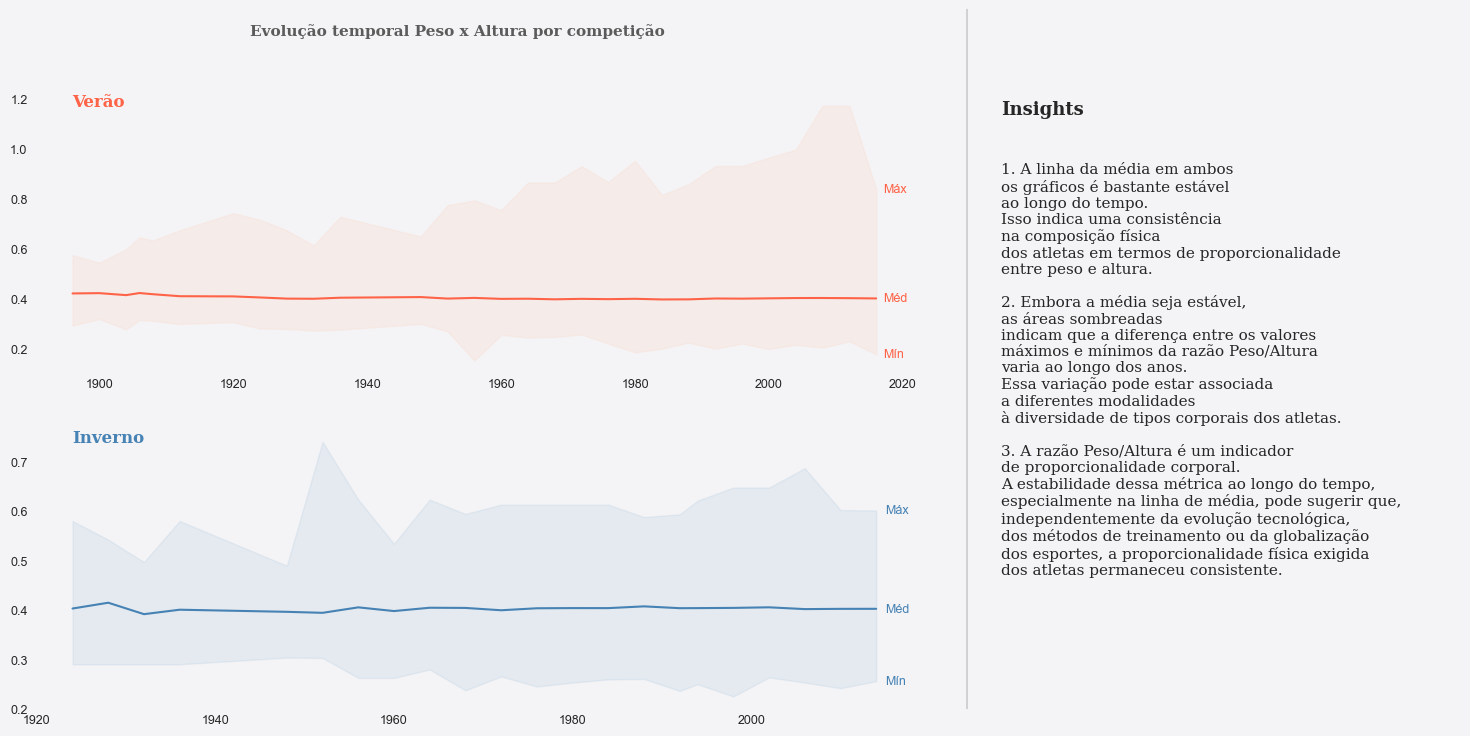

In [167]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(17,7), facecolor=cor_fundo_padrao)

peso_altura['Peso_Altura'] = peso_altura['Weight'] / peso_altura['Height']

# Grafico 1: Evolução do Peso médio - Verão
peso_altura_ano_v = peso_altura.query("Season == 'Summer'").groupby('Year').agg({
    'Peso_Altura': ['mean', 'min', 'max']
})

peso_altura_ano_v = peso_altura_ano_v['Peso_Altura'].reset_index()

ax.plot(peso_altura_ano_v['Year'], peso_altura_ano_v['mean'], linestyle='-', color=cores_verao[-1])
ax.fill_between(peso_altura_ano_v['Year'], peso_altura_ano_v['min'],
                peso_altura_ano_v['max'], color=cores_verao[0], alpha=0.2)
ax.set_facecolor(cor_fundo_padrao)

# Adicionar rótulos no final das linhas
ax.text(peso_altura_ano_v['Year'].iloc[-1] + 1, peso_altura_ano_v['mean'].iloc[-1], 'Méd',
        color=cores_verao[-1], fontsize=9, fontweight='light', va='center')
ax.text(peso_altura_ano_v['Year'].iloc[-1] + 1, peso_altura_ano_v['min'].iloc[-1], 'Mín',
        color=cores_verao[-1], fontsize=9, fontweight='light', va='center')
ax.text(peso_altura_ano_v['Year'].iloc[-1] + 1, peso_altura_ano_v['max'].iloc[-1], 'Máx',
        color=cores_verao[-1], fontsize=9, fontweight='light', va='center')


# Grafico 2: Evolução do Altura média - Inverno
peso_altura_ano_i = peso_altura.query("Season == 'Winter'").groupby('Year').agg({
    'Peso_Altura': ['mean', 'min', 'max']
})

peso_altura_ano_i = peso_altura_ano_i['Peso_Altura'].reset_index()

ax2.plot(peso_altura_ano_i['Year'], peso_altura_ano_i['mean'], linestyle='-', color=cores_inverno[-1])
ax2.fill_between(peso_altura_ano_i['Year'], peso_altura_ano_i['min'],
                peso_altura_ano_i['max'], color=cores_inverno[0], alpha=0.2)
ax2.set_facecolor(cor_fundo_padrao)

# Adicionar rótulos no final das linhas
ax2.text(peso_altura_ano_i['Year'].iloc[-1] + 1, peso_altura_ano_i['mean'].iloc[-1], 'Méd',
        color=cores_inverno[-1], fontsize=9, fontweight='light', va='center')
ax2.text(peso_altura_ano_i['Year'].iloc[-1] + 1, peso_altura_ano_i['min'].iloc[-1], 'Mín',
        color=cores_inverno[-1], fontsize=9, fontweight='light', va='center')
ax2.text(peso_altura_ano_i['Year'].iloc[-1] + 1, peso_altura_ano_i['max'].iloc[-1], 'Máx',
        color=cores_inverno[-1], fontsize=9, fontweight='light', va='center')

# Ajustando os eixos
for ax_ in [ax,ax2, ax3]:
    ax_.grid()
    for s in ['top', 'left', 'right', 'bottom']:
        ax_.spines[s].set_visible(False)
    ax_.tick_params(axis='both', which='major', labelsize=9)
    ax_.tick_params(axis='both', which='both',length=0)
    ax_.set_facecolor(cor_fundo_padrao)

ax.text(x=int(peso_altura_ano_v['Year'].min()), y=float(peso_altura_ano_v['max'].max()),s='Verão',
        color=cores_verao[-1],fontsize=12, fontweight='bold', fontfamily='serif')

ax2.text(x=int(peso_altura_ano_i['Year'].min()), y=float(peso_altura_ano_i['max'].max()),s='Inverno',
        color=cores_inverno[-1],fontsize=12, fontweight='bold', fontfamily='serif')

texto1 = '''Insights'''
texto2 = '''
1. A linha da média em ambos
os gráficos é bastante estável
ao longo do tempo.
Isso indica uma consistência 
na composição física
dos atletas em termos de proporcionalidade
entre peso e altura.

2. Embora a média seja estável, 
as áreas sombreadas
indicam que a diferença entre os valores
máximos e mínimos da razão Peso/Altura
varia ao longo dos anos.
Essa variação pode estar associada 
a diferentes modalidades
à diversidade de tipos corporais dos atletas.

3. A razão Peso/Altura é um indicador 
de proporcionalidade corporal. 
A estabilidade dessa métrica ao longo do tempo,
especialmente na linha de média, pode sugerir que,
independentemente da evolução tecnológica,
dos métodos de treinamento ou da globalização
dos esportes, a proporcionalidade física exigida
dos atletas permaneceu consistente.
'''

l1 = lines.Line2D([0.7, 0.7], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
l2 = lines.Line2D([0.99, 0.99], [0, 1], transform=fig.transFigure, figure=fig,color=cor_fundo_padrao,lw=0.2)
fig.lines.extend([l1, l2])

fig.text(0.72, 0.85, texto1, fontsize=13, fontweight='bold', fontfamily='serif',ha='left')
fig.text(0.72, 0.17, texto2, fontsize=11, fontweight='light', fontfamily='serif',ha='left')

fig.suptitle('Evolução temporal Peso x Altura por competição',
            color=cinzas[-2], fontsize=11, fontweight='bold', fontfamily='serif', x=0.4)

#plt.tight_layout()

plt.subplots_adjust(left=0.15, right=0.67, top=0.88, bottom=-0)

## Brasil
___

Aqui poderemos ter uma visão geral do progresso do nosso País nas competições.

In [168]:
brasil_dados = mesclado[mesclado['region'] == 'Brazil']


### Participção por gênero

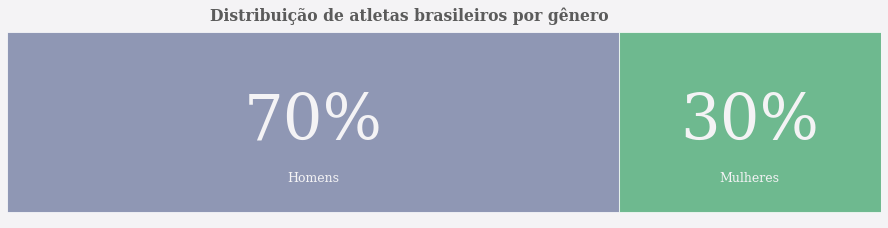

In [232]:
brasil_atletas = brasil_dados.drop_duplicates(subset=['Year', 'ID'])

brasil_atletas_gen = brasil_atletas.groupby(['Sex'])['Sex'].count()
brasil_atletas_gen

y=brasil_atletas_gen.sum()
r=((brasil_atletas_gen/y)).round(2)
mf_ratio = pd.DataFrame(r).T

fig, ax = plt.subplots(1,1,figsize=(12, 3), dpi=75, facecolor=cor_fundo_padrao)
ax.set_facecolor(cor_fundo_padrao)
ax.barh(mf_ratio.index, mf_ratio['M'], color='#657099', alpha=0.7, label='Male')
ax.barh(mf_ratio.index, mf_ratio['F'], left=mf_ratio['M'], color= '#35A164', alpha=0.7, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['M'][i]*100)}%", 
                    xy=(mf_ratio['M'][i]/2, i),
                    va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                    color=cor_fundo_padrao)

    ax.annotate("Homens", 
                    xy=(mf_ratio['M'][i]/2, -0.25),
                    va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                    color=cor_fundo_padrao)
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['F'][i]*100)}%", 
                    xy=(mf_ratio['M'][i]+mf_ratio['F'][i]/2, i),
                    va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                    color=cor_fundo_padrao)
    ax.annotate("Mulheres", 
                    xy=(mf_ratio['M'][i]+mf_ratio['F'][i]/2, -0.25),
                    va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                    color=cor_fundo_padrao)

# Title & Subtitle
fig.text(0.24,.95,'Distribuição de atletas brasileiros por gênero',
          fontfamily='serif',fontsize=15, fontweight='bold', color=cinzas[1])

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

# Removing legend due to labelled plot
ax.legend().set_visible(False)

plt.tight_layout()
   

### Medalhas

#### Distribuição por competição
Aqui veremos a distribuição de medalhas recebidas nos diferentes anos de competição

In [304]:
medalhas_brasil = brasil_dados[brasil_dados['Medal'].notna()]
medalhas_brasil = medalhas_brasil.groupby(['Year', 'Medal'])['Year'].count().unstack().fillna(0).reset_index()
medalhas_brasil['Total'] = medalhas_brasil['Bronze'] + medalhas_brasil['Silver'] + medalhas_brasil['Gold']
medalhas_brasil[['Total', 'Silver', 'Gold','Bronze']] = medalhas_brasil[['Total', 'Silver', 'Gold','Bronze']].astype(int)

# Buscando a média de medalhas recebidas por pais divididas por competicao
medalhas_dados = mesclado.query('Season == "Summer"')[mesclado['Medal'].notna()]
medalhas_por_pais_ano = medalhas_dados.groupby(['Year', 'region']).size().reset_index(name='Medal_Count')
media_medalhas_por_ano = medalhas_por_pais_ano.groupby('Year')['Medal_Count'].mean().reset_index(name='Average_Medals')

max_brasil = medalhas_brasil['Total'].max()

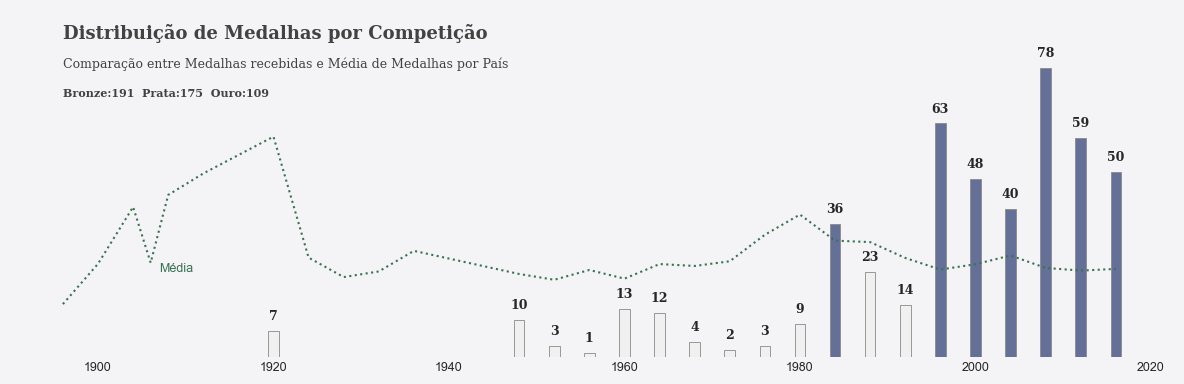

In [339]:
fig, ax = plt.subplots(1,1, figsize=(12,4), facecolor=cor_fundo_padrao)

color_map = ['#F0F0F0' for _ in range(0, len(medalhas_brasil['Year']))]   # Definindo as cores

for i, e in enumerate(medalhas_brasil['Year']):
    year = medalhas_brasil.iloc[i]['Year']
    total_medalhas = medalhas_brasil.iloc[i]['Total']
    average_medalhas = media_medalhas_por_ano.loc[media_medalhas_por_ano['Year'] == year, 'Average_Medals'].values[0]

    if total_medalhas >= average_medalhas:
       color_map[i] = '#657099' 

# Plotando os graficos em seus eixos
ax.bar(x=medalhas_brasil['Year'], height=medalhas_brasil['Total'],width=1.2, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map
       )

ax.plot(media_medalhas_por_ano['Year'], media_medalhas_por_ano['Average_Medals'],
        linestyle=':', color='#397252')

for ax_ in [ax,ax2, ax3]:
    ax_.grid()
    ax_.tick_params(axis='both', which='major', labelsize=9)
    ax_.tick_params(axis='both', which='both',length=0)
    ax_.set_yticklabels([])
    ax_.set_ylim(0, max_brasil*1.2)
    ax_.set_facecolor(cor_fundo_padrao)
    for s in ['top', 'left', 'right', 'bottom']:
        ax_.spines[s].set_visible(False)

for i, e in enumerate(medalhas_brasil['Year']):
    year = medalhas_brasil.iloc[i]['Year']
    valor = medalhas_brasil.iloc[i]['Total']

    ax.annotate(f"{formata_valor(valor)}",
            xy=(e, valor + max_brasil*.05),
            va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=9
            )

ax.text(x=media_medalhas_por_ano['Year'].min(),
        y=max_brasil*1.1,
        s='Distribuição de Medalhas por Competição',
        fontweight='bold', fontfamily='serif', fontsize=13, color=cinzas[-1])
ax.text(x=media_medalhas_por_ano['Year'].min(),
        y=max_brasil*1,
        s='Comparação entre Medalhas recebidas e Média de Medalhas por País',
        fontweight='light', fontfamily='serif', fontsize=9, color=cinzas[-1])
ax.text(
    x=media_medalhas_por_ano['Year'].min(),
    y=max_brasil*0.9,
    s=f'Bronze:{medalhas_brasil['Bronze'].sum()}  Prata:{medalhas_brasil['Silver'].sum()}  Ouro:{medalhas_brasil['Gold'].sum()}',
    fontweight='bold', fontfamily='serif', fontsize=8, color=cinzas[-1]
)

# Adicionar rótulos no final das linhas
ax.text(media_medalhas_por_ano['Year'].iloc[3] + 1, media_medalhas_por_ano['Average_Medals'].iloc[-1], 'Média',
        color="#397252", fontsize=9, fontweight='light', va='center')

plt.tight_layout()

#### Distribuição por Esportes
Aqui apresentarei um panorama geral de Medalhas por Esporte.

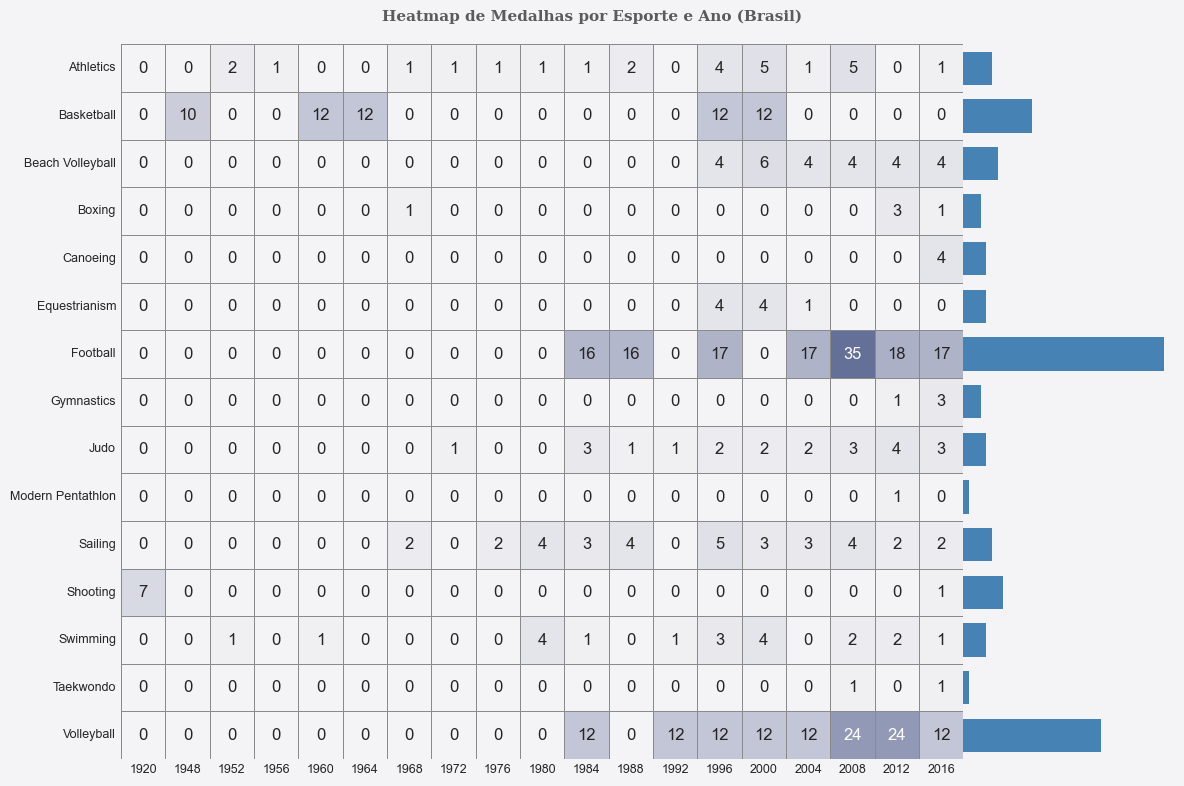

In [407]:
brasil_esportes = brasil_dados[brasil_dados['Medal'].notna()]
brasil_esportes = brasil_esportes.groupby(['Year', 'Sport','Medal'])['Medal'].count().unstack().reset_index().fillna(0)
#brasil_esportes = brasil_esportes.reset_index()['Sport'].value_counts().reset_index()

brasil_esportes['Total_Medals'] = brasil_esportes['Bronze'] + brasil_esportes['Gold'] + brasil_esportes['Silver']
heatmap_data = brasil_esportes.pivot_table(index='Sport', columns='Year', values='Total_Medals', aggfunc='sum').fillna(0)

# Criar um colormap linear personalizado
cores = [cor_fundo_padrao, '#657099']
cmap = LinearSegmentedColormap.from_list("custom_cmap", cores)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 8), facecolor=cor_fundo_padrao, gridspec_kw={'width_ratios': [4, 1], 'wspace': 0})
# Criar o gráfico de calor
ax = sns.heatmap(heatmap_data, annot=True, fmt="g", cmap=cmap,cbar=False,  linewidths=0.5, linecolor=cinzas[0], ax=ax)

# Criar um grafico de barras
esportes_ordenados = heatmap_data.index
brasil_esportes_ordenado = brasil_esportes.set_index('Sport').\
    loc[esportes_ordenados].reset_index().sort_index(ascending=False)
ax2.barh(brasil_esportes_ordenado['Sport'], brasil_esportes_ordenado['Total_Medals'],
          color=cores_inverno[-1], edgecolor='none', height=0.7)

# Inserindo os rotulos de dados
for e in brasil_esportes_ordenado['Sport'].unique():
    ax.annotate(f"{formata_valor(top_20_esportes_ouro.at[i, 'count'])}", 
                xy=(i, top_20_esportes_ouro.at[i, 'count'] + max_*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=9)

ax2.set_ylim(-0.5, len(esportes_ordenados) - 0.5)

for ax_ in [ax,ax2]:
    ax_.grid()
    ax_.tick_params(axis='both', which='major', labelsize=9)
    ax_.tick_params(axis='both', which='both',length=0)
    ax_.set_facecolor(cor_fundo_padrao)
    ax_.set_xlabel('')
    ax_.set_ylabel('')
    for s in ['top', 'left', 'right', 'bottom']:
        ax_.spines[s].set_visible(False)

ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Remover espaços entre os gráficos e alinhar os esportes
ax2.yaxis.set_ticks_position('none')  # Remove os ticks do eixo y
ax2.yaxis.set_tick_params(pad=-2)  # Aproxima mais as barras do heatmap

plt.suptitle(
    'Heatmap de Medalhas por Esporte e Ano (Brasil)',
     color=cinzas[-2], fontsize=11, fontweight='bold', fontfamily='serif'
    )
plt.tight_layout()

### Atletas Brasileiros
Vamos finalizar a anlise do Brasil, direcionando nossa atenção para os atleras dos dois esportes que se destacam no quesito medalhas.

#### Futebol


In [459]:
medalhas_brasil = brasil_dados[(brasil_dados['Medal'].notna())]
brasil_fut = medalhas_brasil[medalhas_brasil['Sport'] == 'Football']

brasil_fut['Age'] = brasil_fut['Age'].astype(int)

Text(1984, 100.80000000000001, '\nAssim como a altura, o Peso médio também reduziu em 2015\npor conta da entrada feminina no esporte\n    ')

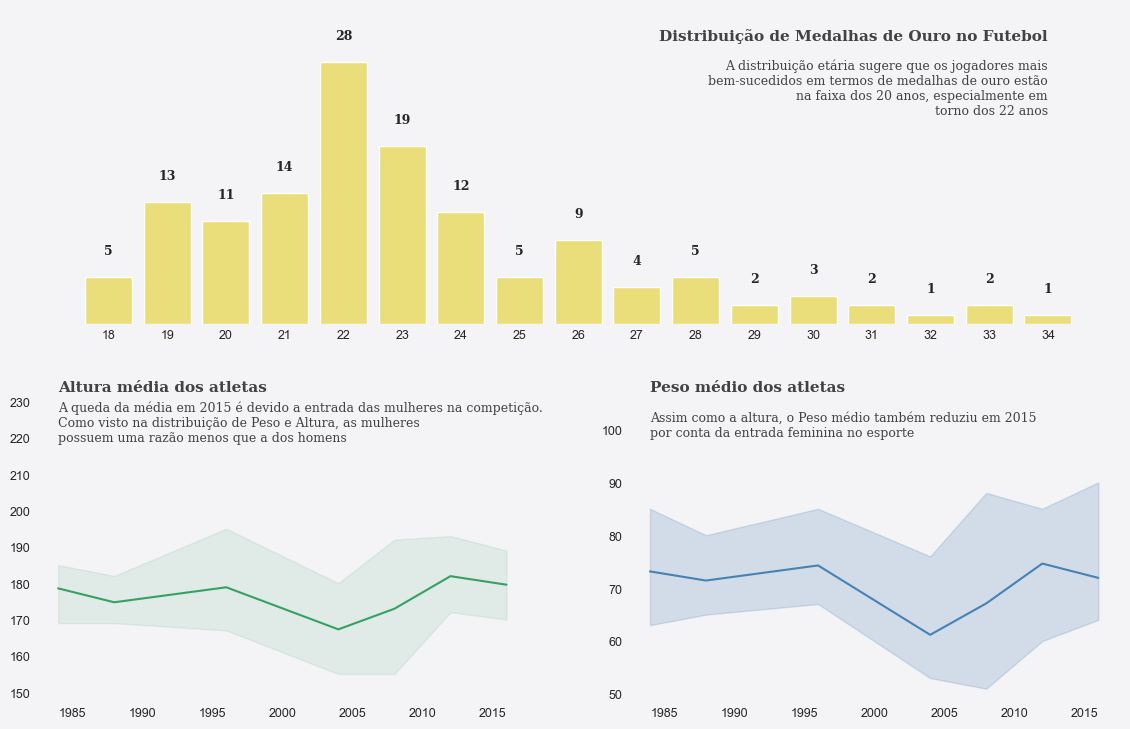

In [538]:

fig = plt.figure(figsize=(14,9), facecolor=cor_fundo_padrao)

# Primeiro subplot que ocupa toda a linha superior
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)

# Segundo subplot na segunda linha, primeira coluna
ax2 = plt.subplot2grid((2, 2), (1, 0))

# Terceiro subplot na segunda linha, segunda coluna
ax3 = plt.subplot2grid((2, 2), (1, 1))

# Grafico 1 - Distribuicao de Medalhas por Idade
brasil_fut_idade = brasil_fut['Age'].value_counts().reset_index()
ax.bar(x=brasil_fut_idade['Age'], height=brasil_fut_idade['count'], color='#E9DE7A')

# Grafico 2 - Altura por competicao
altura_fut = brasil_fut.groupby('Year').agg({
    'Height': ['mean', 'min', 'max']
})

altura_fut = altura_fut['Height']

ax2.plot(altura_fut.index, altura_fut['mean'], linestyle='-', color='#35A164')
ax2.fill_between(altura_fut.index, altura_fut['min'],
                altura_fut['max'], color='#35A164', alpha=0.1)

# Grafico 3 - Peso por competicao
peso_fut = brasil_fut.groupby('Year').agg({
    'Weight': ['mean', 'min', 'max']
})

peso_fut = peso_fut['Weight']

ax3.plot(peso_fut.index, peso_fut['mean'], linestyle='-', color='#4682B4')
ax3.fill_between(peso_fut.index, peso_fut['min'],
                peso_fut['max'], color='#4682B4', alpha=0.2)

# Ajustando os eixos
for ax_ in [ax,ax2, ax3]:
    ax_.grid()
    for s in ['top', 'left', 'right', 'bottom']:
        ax_.spines[s].set_visible(False)
    ax_.tick_params(axis='both', which='major', labelsize=9)
    ax_.tick_params(axis='both', which='both',length=0)
    ax_.set_facecolor(cor_fundo_padrao)

ax.set_yticklabels([])

ax.set_xticks(brasil_fut_idade['Age'])
ax.set_ylim(0, float(brasil_fut_idade['count'].max()) * 1.2)
ax2.set_ylim(float(altura_fut['min'].min())*0.95, float(altura_fut['max'].max()) * 1.2)
ax3.set_ylim(float(peso_fut['min'].min()) * 0.95, float(peso_fut['max'].max()) * 1.2)

# Inserindo os rotulos de dados
for i in brasil_fut_idade.index:
    idade = brasil_fut_idade.loc[i,'Age']
    valor = brasil_fut_idade.loc[i,'count']
    ax.annotate(
        f"{formata_valor(valor)}",
        xy=(idade, valor + float(brasil_fut_idade['count'].max())*.1),
        va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=9
        )
    
# Textos
ax.text(
    brasil_fut_idade['Age'].max(), float(brasil_fut_idade['count'].max())*1.1,
    'Distribuição de Medalhas de Ouro no Futebol',
    color=cinzas[-1], fontsize=11, fontweight='bold', va='center', ha='right', fontfamily='serif'
)

ax.text(
    brasil_fut_idade['Age'].max(), float(brasil_fut_idade['count'].max())*.9,
    '''A distribuição etária sugere que os jogadores mais
    bem-sucedidos em termos de medalhas de ouro estão
    na faixa dos 20 anos, especialmente em
    torno dos 22 anos''',
    color=cinzas[-1], fontsize=9, fontweight='light', va='center', ha='right', fontfamily='serif'
)

ax2.text(
    altura_fut.index.min(), float(altura_fut['max'].max()) * 1.2,
    'Altura média dos atletas',
    color=cinzas[-1], fontsize=11, fontweight='bold', va='center', ha='left', fontfamily='serif'
)
ax2.text(
    altura_fut.index.min(), float(altura_fut['max'].max()) * 1.15,
    '''
A queda da média em 2015 é devido a entrada das mulheres na competição.
Como visto na distribuição de Peso e Altura, as mulheres
possuem uma razão menos que a dos homens
    ''',
    color=cinzas[-1], fontsize=9, fontweight='light', va='center', ha='left', fontfamily='serif'
)

ax3.text(
    peso_fut.index.min(), float(peso_fut['max'].max()) * 1.2,
    'Peso médio dos atletas',
    color=cinzas[-1], fontsize=11, fontweight='bold', va='center', ha='left', fontfamily='serif'
)

ax3.text(
    peso_fut.index.min(), float(peso_fut['max'].max()) * 1.13,
    '''
Assim como a altura, o Peso médio também reduziu em 2015
por conta da entrada feminina no esporte
    ''',
    color=cinzas[-1], fontsize=9, fontweight='light', va='center', ha='left', fontfamily='serif'
)


In [522]:
altura_fut.index

Index([1984, 1988, 1996, 2004, 2008, 2012, 2016], dtype='int64', name='Year')